# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [184]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
import math
from pylab import rcParams
import seaborn as sns
import scipy.stats as ss
from itertools import accumulate

# sagemaker libraries
import boto3

# magic word for producing visualizations in notebook
%matplotlib inline

In [11]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# fix some options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
rcParams['agg.path.chunksize'] = 10000

# Be sure to add in a lot more cells (both markdown and code) to document your approach and findings!
#azdias1 = azdias.dropna()
#customers1 = customers.dropna()


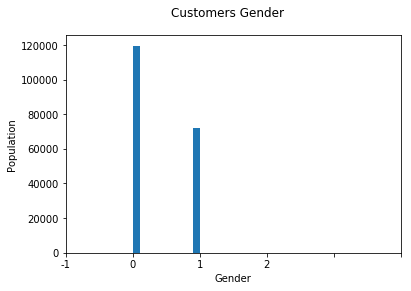

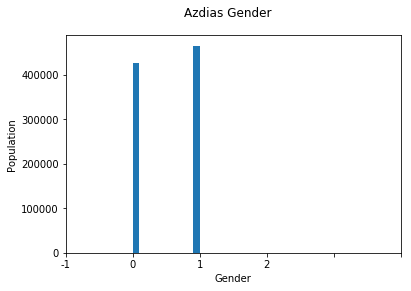

In [7]:
columnName = 'ANREDE_KZ'
xLabelName = 'Population'
xTickString = ['-1', '0', '1', '2']
arrangeData = 6
ages = customers[columnName].values
xLabel = 'Gender'
yLabel = 'Population'
#display(ages)

plt.hist(ages)
plt.xticks(np.arange(arrangeData), xTickString) # Set text labels.
plt.suptitle('Customers Gender')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.show()

###

plt.hist(azdias[columnName].values)
plt.xticks(np.arange(arrangeData), xTickString) # Set text labels.
plt.suptitle('Azdias Gender')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.show()


In [142]:
# Data Cleanup

## First, cleanup columns
## Second, cleanup rows

# create copy of customer dataframe
customersC = customers.copy()
#print(list(customersC.columns))

# 1. make all the missing values to nan

## 1.1 create a dictionary of all key to value pairs for missing values
missingValuesDictionary = {
    'AGER_TYP' : ['-1'], # unknown
    'ALTERSKATEGORIE_GROB' : ['-1', '0'], # unknown
    'ALTER_HH' : ['0'], # unknown
    'ANREDE_KZ' : ['-1', '0'], # unknown
    'BALLRAUM' : ['-1'], # unknown
    'BIP_FLAG' : ['-1'], # unknown
    'CAMEO_DEUG_2015' : ['-1', 'XX', 'X'], # unknown
    'CAMEO_DEUINTL_2015' : ['-1'], # unknown
    'CAMEO_INTL_2015' : ['XX', 'X'], # unknown
    'CJT_GESAMTTYP' : ['0'], # unknown
    ##'D19_BANKEN_ANZ_12' : ['0'], # not known
    ##'D19_BANKEN_ANZ_24' : ['0'], # not known
    ##'D19_BANKEN_DATUM' : ['10'], # not known
    #'D19_BANKEN_DIREKT_RZ' : ['0'], # not known
    #'D19_BANKEN_GROSS_RZ' : ['0'], # not known
    #'D19_BANKEN_LOKAL_RZ' : ['0'], # not known
    ##'D19_BANKEN_OFFLINE_DATUM' : ['10'], # not known
    ##'D19_BANKEN_ONLINE_DATUM' : ['10'], # not known
    ##'D19_BANKEN_ONLINE_QUOTE_12' : ['0'], # none
    #'D19_BANKEN_REST_RZ' : ['0'], # not known
    #'D19_BEKLEIDUNG_GEH_RZ' : ['0'], # not known
    #'D19_BEKLEIDUNG_REST_RZ' : ['0'], # not known
    #'D19_BILDUNG_RZ' : ['0'], # not known
    #'D19_BIO_OEKO_RZ' : ['0'], # not known
    #'D19_BUCH_RZ' : ['0'], # not known
    #'D19_DIGIT_SERV_RZ' : ['0'], # not known
    #'D19_DROGERIEARTIKEL_RZ' : ['0'], # not known
    #'D19_ENERGIE_RZ' : ['0'], # not known
    #'D19_FREIZEIT_RZ' : ['0'], # not known
    #'D19_GARTEN_RZ' : ['0'], # not known
    ##'D19_GESAMT_ANZ_12' : ['0'], # not known
    ##'D19_GESAMT_ANZ_24' : ['0'], # not known
    ##'D19_GESAMT_DATUM' : ['10'], # not known
    ##'D19_GESAMT_OFFLINE_DATUM' : ['10'], # not known
    ##'D19_GESAMT_ONLINE_DATUM' : ['10'], # not known
    ##'D19_GESAMT_ONLINE_QUOTE_12' : ['0'], # not known
    #'D19_HANDWERK_RZ' : ['0'], # not known
    #'D19_HAUS_DEKO_RZ' : ['0'], # not known
    #'D19_KINDERARTIKEL_RZ' : ['0'], # not known
    ##'D19_KONSUMTYP' : ['9'], #inactive, consumption type
    #'D19_KK_KUNDENTYP' : ['-1'], # unknown
    #'D19_KOSMETIK_RZ' : ['0'], # not known
    #'D19_LEBENSMITTEL_RZ' : ['0'], # not known
    #'D19_LOTTO_RZ' : ['0'], # not known
    #'D19_NAHRUNGSERGAENZUNG_RZ' : ['0'], # not known
    #'D19_RATGEBER_RZ' : ['0'], # not known
    #'D19_REISEN_RZ' : ['0'], # not known
    #'D19_SAMMELARTIKEL_RZ' : ['0'], # not known
    #'D19_SCHUHE_RZ' : ['0'], # not known
    #'D19_SONSTIGE_RZ' : ['0'], # not known
    #'D19_TECHNIK_RZ' : ['0'], # not known
    ##'D19_TELKO_ANZ_12' : ['0'], # not known
    ##'D19_TELKO_ANZ_24' : ['0'], # not known
    ##'D19_TELKO_DATUM' : ['10'], # not known
    #'D19_TELKO_MOBILE_RZ' : ['0'], # not known
    ##'D19_TELKO_OFFLINE_DATUM' : ['10'], # not known
    ##'D19_TELKO_ONLINE_DATUM' : ['10'], # not known
    #'D19_TELKO_REST_RZ' : ['0'], # not known
    #'D19_TIERARTIKEL_RZ' : ['0'], # not known
    ##'D19_VERSAND_ANZ_12' : ['0'], # not known
    ##'D19_VERSAND_ANZ_24' : ['0'], # not known
    ##'D19_VERSAND_DATUM' : ['10'], # not known
    ##'D19_VERSAND_OFFLINE_DATUM' : ['10'], # not known
    ##'D19_VERSAND_ONLINE_DATUM' : ['10'], # not known
    ##'D19_VERSAND_ONLINE_QUOTE_12' : ['0'], #none
    #'D19_VERSAND_REST_RZ' : ['0'], # not known
    #'D19_VERSICHERUNGEN_RZ' : ['0'], # not known
    ##'D19_VERSI_ANZ_12' : ['0'], # not known
    ##'D19_VERSI_ANZ_24' : ['0'], # not known
    #'D19_VOLLSORTIMENT_RZ' : ['0'], # not known
    #'D19_WEIN_FEINKOST_RZ' : ['0'], # not known
    'EWDICHTE' : ['-1'], # unknown
    'FINANZTYP' : ['-1'], # unknown
    'FINANZ_ANLEGER' : ['-1'], # unknown
    'FINANZ_HAUSBAUER' : ['-1'], # unknown
    'FINANZ_MINIMALIST' : ['-1'], # unknown
    'FINANZ_SPARER' : ['-1'], # unknown
    'FINANZ_UNAUFFAELLIGER' : ['-1'], # unknown
    'FINANZ_VORSORGER' : ['-1'], # unknown
    'GEBAEUDETYP' : ['-1', '0'], # unknown
    'GEBURTSJAHR' : ['0'],
    'GEOSCORE_KLS7' : ['-1', '0'], # unknown
    'HAUSHALTSSTRUKTUR' : ['-1', '0'], # unknown
    'HEALTH_TYP' : ['-1'], # unknown
    'HH_EINKOMMEN_SCORE' : ['-1', '0'], # unknown
    'INNENSTADT' : ['-1'], # unknown
    'KBA05_ALTER1' : ['-1', '9'], # unknown
    'KBA05_ALTER2' : ['-1', '9'], # unknown
    'KBA05_ALTER3' : ['-1', '9'], # unknown
    'KBA05_ALTER4' : ['-1', '9'], # unknown
    'KBA05_ANHANG' : ['-1', '9'], # unknown
    'KBA05_ANTG1' : ['-1'], # unknown
    'KBA05_ANTG2' : ['-1'], # unknown
    'KBA05_ANTG3' : ['-1'], # unknown
    'KBA05_ANTG4' : ['-1'], # unknown
    'KBA05_AUTOQUOT' : ['-1', '9'], # unknown
    'KBA05_BAUMAX' : ['-1', '0'], # unknown
    'KBA05_CCM1' : ['-1', '9'], # unknown
    'KBA05_CCM2' : ['-1', '9'], # unknown
    'KBA05_CCM3' : ['-1', '9'], # unknown
    'KBA05_CCM4' : ['-1', '9'], # unknown
    'KBA05_DIESEL' : ['-1', '9'], # unknown
    'KBA05_FRAU' : ['-1', '9'], # unknown
    'KBA05_GBZ' : ['-1', '0'], # unknown
    'KBA05_HERST1' : ['-1', '9'], # unknown
    'KBA05_HERST2' : ['-1', '9'], # unknown
    'KBA05_HERST3' : ['-1', '9'], # unknown
    'KBA05_HERST4' : ['-1', '9'], # unknown
    'KBA05_HERST5' : ['-1', '9'], # unknown
    'KBA05_HERSTTEMP' : ['-1', '9'], # unknown
    'KBA05_KRSAQUOT' : ['-1', '9'], # unknown
    'KBA05_KRSHERST1' : ['-1', '9'], # unknown
    'KBA05_KRSHERST2' : ['-1', '9'], # unknown
    'KBA05_KRSHERST3' : ['-1', '9'], # unknown
    'KBA05_KRSKLEIN' : ['-1', '9'], # unknown
    'KBA05_KRSOBER' : ['-1', '9'], # unknown
    'KBA05_KRSVAN' : ['-1', '9'], # unknown
    'KBA05_KRSZUL' : ['-1', '9'], # unknown
    'KBA05_KW1' : ['-1', '9'], # unknown
    'KBA05_KW2' : ['-1', '9'], # unknown
    'KBA05_KW3' : ['-1', '9'], # unknown
    'KBA05_MAXAH' : ['-1', '9'], # unknown
    'KBA05_MAXBJ' : ['-1', '9'], # unknown
    'KBA05_MAXHERST' : ['-1', '9'], # unknown
    'KBA05_MAXSEG' : ['-1', '9'], # unknown
    'KBA05_MAXVORB' : ['-1', '9'], # unknown
    'KBA05_MOD1' : ['-1', '9'], # unknown
    'KBA05_MOD2' : ['-1', '9'], # unknown
    'KBA05_MOD3' : ['-1', '9'], # unknown
    'KBA05_MOD4' : ['-1', '9'], # unknown
    'KBA05_MOD8' : ['-1', '9'], # unknown
    'KBA05_MODTEMP' : ['-1', '9'], # unknown
    'KBA05_MOTOR' : ['-1', '9'], # unknown
    'KBA05_MOTRAD' : ['-1', '9'], # unknown
    'KBA05_SEG1' : ['-1', '9'], # unknown
    'KBA05_SEG10' : ['-1', '9'], # unknown
    'KBA05_SEG2' : ['-1', '9'], # unknown
    'KBA05_SEG3' : ['-1', '9'], # unknown
    'KBA05_SEG4' : ['-1', '9'], # unknown
    'KBA05_SEG5' : ['-1', '9'], # unknown
    'KBA05_SEG6' : ['-1', '9'], # unknown
    'KBA05_SEG7' : ['-1', '9'], # unknown
    'KBA05_SEG8' : ['-1', '9'], # unknown
    'KBA05_SEG9' : ['-1', '9'], # unknown
    'KBA05_VORB0' : ['-1', '9'], # unknown
    'KBA05_VORB1' : ['-1', '9'], # unknown
    'KBA05_VORB2' : ['-1', '9'], # unknown
    'KBA05_ZUL1' : ['-1', '9'], # unknown
    'KBA05_ZUL2' : ['-1', '9'], # unknown
    'KBA05_ZUL3' : ['-1', '9'], # unknown
    'KBA05_ZUL4' : ['-1', '9'], # unknown
    'KBA13_ALTERHALTER_30' : ['-1'], # unknown
    'KBA13_ALTERHALTER_45' : ['-1'], # unknown
    'KBA13_ALTERHALTER_60' : ['-1'], # unknown
    'KBA13_ALTERHALTER_61' : ['-1'], # unknown
    'KBA13_AUDI' : ['-1'], # unknown
    'KBA13_AUTOQUOTE' : ['-1'], # unknown
    'KBA13_BJ_1999' : ['-1'], # unknown
    'KBA13_BJ_2000' : ['-1'], # unknown
    'KBA13_BJ_2004' : ['-1'], # unknown
    'KBA13_BJ_2006' : ['-1'], # unknown
    'KBA13_BJ_2008' : ['-1'], # unknown
    'KBA13_BJ_2009' : ['-1'], # unknown
    'KBA13_BMW' : ['-1'], # unknown
    'KBA13_CCM_1000' : ['-1'], # unknown
    'KBA13_CCM_1200' : ['-1'], # unknown
    'KBA13_CCM_1400' : ['-1'], # unknown
    'KBA13_CCM_0_1400' : ['-1'], # unknown
    'KBA13_CCM_1500' : ['-1'], # unknown
    'KBA13_CCM_1400_2500' : ['-1'], # unknown
    'KBA13_CCM_1600' : ['-1'], # unknown
    'KBA13_CCM_1800' : ['-1'], # unknown
    'KBA13_CCM_2000' : ['-1'], # unknown
    'KBA13_CCM_2500' : ['-1'], # unknown
    'KBA13_CCM_2501' : ['-1'], # unknown
    'KBA13_CCM_3000' : ['-1'], # unknown
    'KBA13_CCM_3001' : ['-1'], # unknown
    'KBA13_FAB_ASIEN' : ['-1'], # unknown
    'KBA13_FAB_SONSTIGE' : ['-1'], # unknown
    'KBA13_FIAT' : ['-1'], # unknown
    'KBA13_FORD' : ['-1'], # unknown
    'KBA13_HALTER_20' : ['-1'], # unknown
    'KBA13_HALTER_25' : ['-1'], # unknown
    'KBA13_HALTER_30' : ['-1'], # unknown
    'KBA13_HALTER_35' : ['-1'], # unknown
    'KBA13_HALTER_40' : ['-1'], # unknown
    'KBA13_HALTER_45' : ['-1'], # unknown
    'KBA13_HALTER_50' : ['-1'], # unknown
    'KBA13_HALTER_55' : ['-1'], # unknown
    'KBA13_HALTER_60' : ['-1'], # unknown
    'KBA13_HALTER_65' : ['-1'], # unknown
    'KBA13_HALTER_66' : ['-1'], # unknown
    'KBA13_HERST_ASIEN' : ['-1'], # unknown
    'KBA13_HERST_AUDI_VW' : ['-1'], # unknown
    'KBA13_HERST_BMW_BENZ' : ['-1'], # unknown
    'KBA13_HERST_EUROPA' : ['-1'], # unknown
    'KBA13_HERST_FORD_OPEL' : ['-1'], # unknown
    'KBA13_HERST_SONST' : ['-1'], # unknown
    'KBA13_KMH_110' : ['-1'], # unknown
    'KBA13_KMH_140' : ['-1'], # unknown
    'KBA13_KMH_180' : ['-1'], # unknown
    'KBA13_KMH_0_140' : ['-1'], # unknown
    'KBA13_KMH_140_210' : ['-1'], # unknown
    'KBA13_KMH_211' : ['-1'], # unknown
    'KBA13_KMH_250' : ['-1'], # unknown
    'KBA13_KMH_251' : ['-1'], # unknown
    'KBA13_KRSAQUOT' : ['-1'], # unknown
    'KBA13_KRSHERST_AUDI_VW' : ['-1'], # unknown
    'KBA13_KRSHERST_BMW_BENZ' : ['-1'], # unknown
    'KBA13_KRSHERST_FORD_OPEL' : ['-1'], # unknown
    'KBA13_KRSSEG_KLEIN' : ['-1'], # unknown
    'KBA13_KRSSEG_OBER' : ['-1'], # unknown
    'KBA13_KRSSEG_VAN' : ['-1'], # unknown
    'KBA13_KRSZUL_NEU' : ['-1'], # unknown
    'KBA13_KW_30' : ['-1'], # unknown
    'KBA13_KW_40' : ['-1'], # unknown
    'KBA13_KW_50' : ['-1'], # unknown
    'KBA13_KW_60' : ['-1'], # unknown
    'KBA13_KW_0_60' : ['-1'], # unknown
    'KBA13_KW_70' : ['-1'], # unknown
    'KBA13_KW_61_120' : ['-1'], # unknown
    'KBA13_KW_80' : ['-1'], # unknown
    'KBA13_KW_90' : ['-1'], # unknown
    'KBA13_KW_110' : ['-1'], # unknown
    'KBA13_KW_120' : ['-1'], # unknown
    'KBA13_KW_121' : ['-1'], # unknown
    'KBA13_MAZDA' : ['-1'], # unknown
    'KBA13_MERCEDES' : ['-1'], # unknown
    'KBA13_MOTOR' : ['-1'], # unknown
    'KBA13_NISSAN' : ['-1'], # unknown
    'KBA13_OPEL' : ['-1'], # unknown
    'KBA13_PEUGEOT' : ['-1'], # unknown
    'KBA13_RENAULT' : ['-1'], # unknown
    'KBA13_SEG_GELAENDEWAGEN' : ['-1'], # unknown
    'KBA13_SEG_GROSSRAUMVANS' : ['-1'], # unknown
    'KBA13_SEG_KLEINST' : ['-1'], # unknown
    'KBA13_SEG_KLEINWAGEN' : ['-1'], # unknown
    'KBA13_SEG_KOMPAKTKLASSE' : ['-1'], # unknown
    'KBA13_SEG_MINIVANS' : ['-1'], # unknown
    'KBA13_SEG_MINIWAGEN' : ['-1'], # unknown
    'KBA13_SEG_MITTELKLASSE' : ['-1'], # unknown
    'KBA13_SEG_OBEREMITTELKLASSE' : ['-1'], # unknown
    'KBA13_SEG_OBERKLASSE' : ['-1'], # unknown
    'KBA13_SEG_SONSTIGE' : ['-1'], # unknown
    'KBA13_SEG_SPORTWAGEN' : ['-1'], # unknown
    'KBA13_SEG_UTILITIES' : ['-1'], # unknown
    'KBA13_SEG_VAN' : ['-1'], # unknown
    'KBA13_SEG_WOHNMOBILE' : ['-1'], # unknown
    'KBA13_SITZE_4' : ['-1'], # unknown
    'KBA13_SITZE_5' : ['-1'], # unknown
    'KBA13_SITZE_6' : ['-1'], # unknown
    'KBA13_TOYOTA' : ['-1'], # unknown
    'KBA13_VORB_0' : ['-1'], # unknown
    'KBA13_VORB_1' : ['-1'], # unknown
    'KBA13_VORB_1_2' : ['-1'], # unknown
    'KBA13_VORB_2' : ['-1'], # unknown
    'KBA13_VORB_3' : ['-1'], # unknown
    'KBA13_VW' : ['-1'], # unknown
    'KKK' : ['-1', '0'], # unknown
    'MOBI_REGIO' : ['0'], # none
    'NATIONALITAET_KZ' : ['-1', '0'], # unknown
    'ONLINE_AFFINITAET' : ['0'], # none
    'ORTSGR_KLS9' : ['-1'], # unknown
    'OST_WEST_KZ' : ['-1'], # unknown
    'PLZ8_ANTG1' : ['-1'], # unknown
    'PLZ8_ANTG2' : ['-1'], # unknown
    'PLZ8_ANTG3' : ['-1'], # unknown
    'PLZ8_ANTG4' : ['-1'], # unknown
    'PLZ8_GBZ' : ['-1'], # unknown
    'PLZ8_HHZ' : ['-1'], # unknown
    'PRAEGENDE_JUGENDJAHRE' : ['-1', '0'], # unknown
    'REGIOTYP' : ['-1', '0'], # unknown
    'RELAT_AB' : ['-1', '9'], # unknown
    'RETOURTYP_BK_S' : ['0'], # unknown
    'SEMIO_DOM' : ['-1', '9'], # unknown
    'SEMIO_ERL' : ['-1', '9'], # unknown
    'SEMIO_FAM' : ['-1', '9'], # unknown
    'SEMIO_KAEM' : ['-1', '9'], # unknown
    'SEMIO_KRIT' : ['-1', '9'], # unknown
    'SEMIO_KULT' : ['-1', '9'], # unknown
    'SEMIO_LUST' : ['-1', '9'], # unknown
    'SEMIO_MAT' : ['-1', '9'], # unknown
    'SEMIO_PFLICHT' : ['-1', '9'], # unknown
    'SEMIO_RAT' : ['-1', '9'], # unknown
    'SEMIO_REL' : ['-1', '9'], # unknown
    'SEMIO_SOZ' : ['-1', '9'], # unknown
    'SEMIO_TRADV' : ['-1', '9'], # unknown
    'SEMIO_VERT' : ['-1', '9'], # unknown
    'SHOPPER_TYP' : ['-1'], # unknown
    'SOHO_FLAG' : ['-1'], # unknown
    'TITEL_KZ' : ['-1', '0'], # unknown
    'VERS_TYP' : ['-1'], # unknown
    'WOHNDAUER_2008' : ['-1', '0'], # unknown
    'WOHNLAGE' : ['-1'], # unknown
    'WACHSTUMSGEBIET_NB' : ['-1', '0'], # unknown
    'W_KEIT_KIND_HH' : ['-1', '0'], # unknown
    'ZABEOTYP' : ['-1', '9'] # unknown
}

## 1.2 Swap unknown values with Nan
i = 0
for (column_name, column_values) in missingValuesDictionary.items():
    print(i, 'Name: ', column_name)
    i += 1
    #print("VALUES:", column_values)
    
    for value in column_values:
        try:
            customersC.loc[customersC[column_name] == int(value), column_name] = np.nan
        except:
            print('unexpected column header')
            
print(customersC.shape)

0 Name:  AGER_TYP
1 Name:  ALTERSKATEGORIE_GROB
2 Name:  ALTER_HH
3 Name:  ANREDE_KZ
4 Name:  BALLRAUM
5 Name:  BIP_FLAG
unexpected column header
6 Name:  CAMEO_DEUG_2015
unexpected column header
unexpected column header
7 Name:  CAMEO_DEUINTL_2015
unexpected column header
8 Name:  CAMEO_INTL_2015
unexpected column header
unexpected column header
9 Name:  CJT_GESAMTTYP
10 Name:  EWDICHTE
11 Name:  FINANZTYP
12 Name:  FINANZ_ANLEGER
13 Name:  FINANZ_HAUSBAUER
14 Name:  FINANZ_MINIMALIST
15 Name:  FINANZ_SPARER
16 Name:  FINANZ_UNAUFFAELLIGER
17 Name:  FINANZ_VORSORGER
18 Name:  GEBAEUDETYP
19 Name:  GEBURTSJAHR
20 Name:  GEOSCORE_KLS7
unexpected column header
unexpected column header
21 Name:  HAUSHALTSSTRUKTUR
unexpected column header
unexpected column header
22 Name:  HEALTH_TYP
23 Name:  HH_EINKOMMEN_SCORE
24 Name:  INNENSTADT
25 Name:  KBA05_ALTER1
26 Name:  KBA05_ALTER2
27 Name:  KBA05_ALTER3
28 Name:  KBA05_ALTER4
29 Name:  KBA05_ANHANG
30 Name:  KBA05_ANTG1
31 Name:  KBA05_ANTG2


In [143]:
## transform every value to int for two mixed value columns

column_names = ['CAMEO_INTL_2015','CAMEO_DEUG_2015']
for column_name in column_names:
    customersC.loc[customersC[column_name].astype(str).str.contains("XX", na=False), column_name] = np.nan
    customersC.loc[customersC[column_name].astype(str).str.contains("X", na=False), column_name] = np.nan
    customersC.loc[customersC[column_name].isnull(), column_name] = '-112'
    customersC[column_name] = customersC[column_name].astype('int')
    customersC.loc[customersC[column_name] == -112, column_name] = np.nan

print(customersC.shape)

    

(191652, 369)


In [144]:
# 2. Get distribution of missing values for all columns

nanDistribution = customersC.isna().mean().round(4) * 100
nanDistribution = nanDistribution.sort_values(ascending=False)
nanDistribution.plot.bar()
rcParams['figure.figsize'] = 500, 50
plt.show()
display(nanDistribution)

## total 38 columns with 30% or above nans, lets drop those columns

for (column_name, column_value) in nanDistribution.items():
    if column_value > 30.0:
        try:
            print('Column dropped: ', column_name)
            customersC = customersC.drop(columns=[column_name])
        except:
            print('failed to drop column: ', column_name)
        

print(customersC.shape)


ALTER_KIND4                    99.88
ALTER_KIND3                    99.33
TITEL_KZ                       98.79
ALTER_KIND2                    97.34
ALTER_KIND1                    93.86
KK_KUNDENTYP                   58.41
KBA05_BAUMAX                   57.15
GEBURTSJAHR                    48.54
AGER_TYP                       48.06
EXTSEL992                      44.50
ALTER_HH                       35.87
REGIOTYP                       31.34
KKK                            31.34
W_KEIT_KIND_HH                 29.71
KBA05_MOD1                     29.70
KBA05_KRSZUL                   29.70
KBA05_KRSHERST3                29.70
KBA05_SEG7                     29.70
KBA05_SEG6                     29.70
KBA05_SEG5                     29.70
KBA05_SEG4                     29.70
KBA05_SEG3                     29.70
KBA05_SEG2                     29.70
KBA05_SEG10                    29.70
KBA05_KRSKLEIN                 29.70
KBA05_KRSOBER                  29.70
KBA05_KRSVAN                   29.70
K

Column dropped:  ALTER_KIND4
Column dropped:  ALTER_KIND3
Column dropped:  TITEL_KZ
Column dropped:  ALTER_KIND2
Column dropped:  ALTER_KIND1
Column dropped:  KK_KUNDENTYP
Column dropped:  KBA05_BAUMAX
Column dropped:  GEBURTSJAHR
Column dropped:  AGER_TYP
Column dropped:  EXTSEL992
Column dropped:  ALTER_HH
Column dropped:  REGIOTYP
Column dropped:  KKK
(191652, 356)


In [146]:
# 3. Unique value columns

i = 0;
uniqueValuesDistribution = {}
for column_name in customersC.columns.values:
    print(column_name)
    uniqueLength = len(customersC[column_name].unique())
    uniqueValuesDistribution[column_name] = uniqueLength
    
    #if (uniqueLength >= 15):
    print(i, 'ColumnName: ', column_name, 'UniqueLength', uniqueLength)
    print('Unique Values: ', customersC[column_name].unique())
    
    i += 1

LNR
0 ColumnName:  LNR UniqueLength 191652
Unique Values:  [  9626   9628 143872 ..., 148813 148852 148883]
AKT_DAT_KL
1 ColumnName:  AKT_DAT_KL UniqueLength 10
Unique Values:  [  1.   9.   3.   7.   5.   2.  nan   4.   6.   8.]
ALTERSKATEGORIE_FEIN
2 ColumnName:  ALTERSKATEGORIE_FEIN UniqueLength 26
Unique Values:  [ 10.  nan   0.   8.  14.   9.   4.  13.   6.  12.  19.  17.  15.  11.  16.
   7.  18.  21.  25.  20.  24.   5.   2.  22.   3.  23.]
ANZ_HAUSHALTE_AKTIV
3 ColumnName:  ANZ_HAUSHALTE_AKTIV UniqueLength 217
Unique Values:  [   1.   nan    0.    7.   74.    9.   17.   12.   29.    2.   45.   10.
   14.   15.   55.    6.    5.  108.    3.   25.   18.    4.   11.   19.
    8.   26.   43.   63.   47.   16.   31.   57.   37.   13.   22.   20.
   23.   27.  305.   52.   21.   34.   46.   24.   33.   51.  523.  104.
  101.   59.   44.   38.   61.   69.   28.   48.   40.   39.  145.  107.
   32.   76.  117.   87.   84.   41.  286.   92.  222.  119.   71.   36.
  344.   42.   82.  160

63 ColumnName:  D19_SOZIALES UniqueLength 7
Unique Values:  [  1.   0.   5.   4.  nan   3.   2.]
D19_TECHNIK
64 ColumnName:  D19_TECHNIK UniqueLength 8
Unique Values:  [6 0 7 2 4 3 5 1]
D19_TELKO_ANZ_12
65 ColumnName:  D19_TELKO_ANZ_12 UniqueLength 7
Unique Values:  [0 2 1 4 3 6 5]
D19_TELKO_ANZ_24
66 ColumnName:  D19_TELKO_ANZ_24 UniqueLength 7
Unique Values:  [0 1 2 4 3 5 6]
D19_TELKO_DATUM
67 ColumnName:  D19_TELKO_DATUM UniqueLength 10
Unique Values:  [10  7  9  8  5  6  2  1  3  4]
D19_TELKO_MOBILE
68 ColumnName:  D19_TELKO_MOBILE UniqueLength 8
Unique Values:  [0 5 6 3 2 7 4 1]
D19_TELKO_OFFLINE_DATUM
69 ColumnName:  D19_TELKO_OFFLINE_DATUM UniqueLength 10
Unique Values:  [10  9  8  5  1  6  4  3  7  2]
D19_TELKO_ONLINE_DATUM
70 ColumnName:  D19_TELKO_ONLINE_DATUM UniqueLength 10
Unique Values:  [10  9  5  8  6  7  4  2  1  3]
D19_TELKO_ONLINE_QUOTE_12
71 ColumnName:  D19_TELKO_ONLINE_QUOTE_12 UniqueLength 5
Unique Values:  [  0.  10.  nan   5.   3.]
D19_TELKO_REST
72 ColumnName:

Unique Values:  [  2.  nan   3.   4.   1.   5.   6.]
KBA05_MOTOR
156 ColumnName:  KBA05_MOTOR UniqueLength 5
Unique Values:  [  4.  nan   2.   3.   1.]
KBA05_MOTRAD
157 ColumnName:  KBA05_MOTRAD UniqueLength 5
Unique Values:  [  1.  nan   0.   2.   3.]
KBA05_SEG1
158 ColumnName:  KBA05_SEG1 UniqueLength 5
Unique Values:  [  1.  nan   3.   0.   2.]
KBA05_SEG10
159 ColumnName:  KBA05_SEG10 UniqueLength 6
Unique Values:  [  2.  nan   4.   1.   3.   0.]
KBA05_SEG2
160 ColumnName:  KBA05_SEG2 UniqueLength 6
Unique Values:  [  3.  nan   2.   4.   1.   5.]
KBA05_SEG3
161 ColumnName:  KBA05_SEG3 UniqueLength 6
Unique Values:  [  2.  nan   4.   3.   5.   1.]
KBA05_SEG4
162 ColumnName:  KBA05_SEG4 UniqueLength 6
Unique Values:  [  3.  nan   4.   2.   5.   1.]
KBA05_SEG5
163 ColumnName:  KBA05_SEG5 UniqueLength 6
Unique Values:  [  3.  nan   1.   0.   4.   2.]
KBA05_SEG6
164 ColumnName:  KBA05_SEG6 UniqueLength 3
Unique Values:  [  1.  nan   0.]
KBA05_SEG7
165 ColumnName:  KBA05_SEG7 UniqueLength

241 ColumnName:  KBA13_KRSHERST_BMW_BENZ UniqueLength 6
Unique Values:  [  3.  nan   5.   2.   4.   1.]
KBA13_KRSHERST_FORD_OPEL
242 ColumnName:  KBA13_KRSHERST_FORD_OPEL UniqueLength 6
Unique Values:  [  3.  nan   1.   2.   4.   5.]
KBA13_KRSSEG_KLEIN
243 ColumnName:  KBA13_KRSSEG_KLEIN UniqueLength 4
Unique Values:  [  2.  nan   1.   3.]
KBA13_KRSSEG_OBER
244 ColumnName:  KBA13_KRSSEG_OBER UniqueLength 5
Unique Values:  [  2.  nan   1.   3.   0.]
KBA13_KRSSEG_VAN
245 ColumnName:  KBA13_KRSSEG_VAN UniqueLength 5
Unique Values:  [  2.  nan   1.   3.   0.]
KBA13_KRSZUL_NEU
246 ColumnName:  KBA13_KRSZUL_NEU UniqueLength 5
Unique Values:  [  3.  nan   1.   2.   0.]
KBA13_KW_0_60
247 ColumnName:  KBA13_KW_0_60 UniqueLength 6
Unique Values:  [  3.  nan   4.   2.   1.   5.]
KBA13_KW_110
248 ColumnName:  KBA13_KW_110 UniqueLength 7
Unique Values:  [  4.  nan   2.   3.   0.   1.   5.]
KBA13_KW_120
249 ColumnName:  KBA13_KW_120 UniqueLength 7
Unique Values:  [  3.  nan   1.   5.   4.   0.   2.]

Unique Values:  [ 3.  7.  5.  1.  6.  2.  4.]
SEMIO_KULT
325 ColumnName:  SEMIO_KULT UniqueLength 7
Unique Values:  [ 4.  1.  5.  6.  7.  2.  3.]
SEMIO_LUST
326 ColumnName:  SEMIO_LUST UniqueLength 7
Unique Values:  [ 7.  5.  6.  4.  2.  1.  3.]
SEMIO_MAT
327 ColumnName:  SEMIO_MAT UniqueLength 7
Unique Values:  [ 6.  3.  4.  1.  2.  5.  7.]
SEMIO_PFLICHT
328 ColumnName:  SEMIO_PFLICHT UniqueLength 7
Unique Values:  [ 2.  4.  3.  5.  1.  7.  6.]
SEMIO_RAT
329 ColumnName:  SEMIO_RAT UniqueLength 7
Unique Values:  [ 1.  2.  3.  5.  4.  6.  7.]
SEMIO_REL
330 ColumnName:  SEMIO_REL UniqueLength 7
Unique Values:  [ 2.  1.  3.  4.  5.  6.  7.]
SEMIO_SOZ
331 ColumnName:  SEMIO_SOZ UniqueLength 7
Unique Values:  [ 6.  3.  2.  4.  5.  7.  1.]
SEMIO_TRADV
332 ColumnName:  SEMIO_TRADV UniqueLength 7
Unique Values:  [ 1.  4.  3.  2.  5.  6.  7.]
SEMIO_VERT
333 ColumnName:  SEMIO_VERT UniqueLength 7
Unique Values:  [ 6.  7.  3.  5.  2.  4.  1.]
SHOPPER_TYP
334 ColumnName:  SHOPPER_TYP UniqueLength 

In [147]:
#display(uniqueValuesDistribution)

#print(type(uniqueValuesDistribution))

#sortedKeys = sorted(uniqueValuesDistribution.keys())
#print(type(uniqueValuesDistribution))

##for key in sorted(uniqueValuesDistribution, key=uniqueValuesDistribution.get, reverse=True):
  ##  print(key, uniqueValuesDistribution[key])
    
    
##Mixed Values
#CAMEO_DEUG_2015
#CAMEO_INTL_2015


##need one hot encoding
#D19_LETZTER_KAUF_BRANCHE
#CAMEO_DEU_2015
#CAMEO_DEUG_2015
#CAMEO_INTL_2015


## age related, need to use only one
# AGER_TYP, elderly type - passive elderly/cultural elderly
# ALTERSKATEGORIE_GORIE (Age Category)
# ALTER_HH (Age HH - HouseHold)
# GEBURTSJAHR (Year of birth)



In [148]:
dropColumnList = [
    'LNR', # all unique values
    'ANREDE_KZ', # only male and unknown gender, Gender
    'ONLINE_PURCHASE', # we dont know what the values represents
    'UNGLEICHENN_FLAG', # we dont know what the values represents, Different Flag/ Unique ID
    'SOHO_KZ', # we dont know what the values represents
    'KONSUMZELLE', # we dont know what the values represents, Consumer Cell
    'HH_DELTA_FLAG', # we dont know what the values represents
    'DSL_FLAG', # we dont know what the values represents
    'KBA13_ANTG4', # we dont know what the values represents
    ##'STRUKTURTYP', # we dont know what the values represents, Structure Type
    'D19_TELKO_ONLINE_QUOTE_12', # we dont know what the values represents
    'D19_VERSI_ONLINE_QUOTE_12', # we dont know what the values represents
    'KBA13_ANTG3', # we dont know what the values represents
    'KOMBIALTER', # we dont know what the values represents, More Combined
    'VHN', # we dont know what the values represents
    'UMFELD_JUNG', # we dont know what the values represents, Enironment Young
    'UMFELD_ALT', # we dont know what the values represents, Environment Old
    'RT_SCHNAEPPCHEN', # we dont know what the values represents, Discount
    'RT_KEIN_ANREIZ', # we dont know what the values represents, No Incentive
    'KBA13_KMH_210', # we dont know what the values represents
    'KBA13_GBZ', # we dont know what the values represents
    'KBA13_BAUMAX', # we dont know what the values represents
    'KBA13_ANTG2', # we dont know what the values represents
    'KBA13_ANTG1', # we dont know what the values represents
    'FIRMENDICHTE', # we dont know what the values represents, Company Density
    'D19_KONSUMTYP_MAX', # we dont know what the values represents, Consumption Type
    'CJT_TYP_6', # we dont know what the values represents
    'CJT_TYP_5', # we dont know what the values represents
    'CJT_TYP_4', # we dont know what the values represents 
    'CJT_TYP_3', # we dont know what the values represents
    'CJT_TYP_2', # we dont know what the values represents
    'CJT_TYP_1', # we dont know what the values represents
    'CJT_KATALOGNUTZER', # we dont know what the values represents, Catalog Users
    'ARBEIT', # we dont know what the values represents, Job
    'D19_SOZIALES', # we dont know what the values represents, Social
    'MOBI_RASTER', # we dont know what the values represents, mobile grid
    'VHA', # we dont know what the values represents
    ##'RT_UEBERGROESSE', # we dont know what the values represents, OverSize
    ##'D19_BUCH_CD', # we dont know what the values represents, transactional activity based on the product group BOOKS and CDS
    ##'GEMEINDETYP', # we dont know what the values represents, Municipal Type
    'AKT_DAT_KL', # we dont know what the values represents
    ##'ANZ_KINDER', # we dont know what the values represents, Children
    'VK_DHT4A', # we dont know what the values represents
    'VK_ZG11', # we dont know what the values represents
    'VK_DISTANZ', # we dont know what the values represents, Distance
    ##'ANZ_STATISTISCHE_HAUSHALTE', # we dont know what the values represents, Statistical Budget
    ##'D19_LETZTER_KAUF_BRANCHE', # we dont know what the values represents, Last Purchase Industry
    'VERDICHTUNGSRAUM', # we dont know what the values represents, Compression Space
    ##'EINGEZOGENAM_HH_JAHR', # we dont know what the values represents, Moved in HH year
    'EINGEFUEGT_AM', # we dont know what the values represents, Inserted at
    'CAMEO_DEU_2015', # too many values
]

for columnName in dropColumnList:    
    try:
        customersC = customersC.drop(columns=[columnName])
    except:
        print('Already deleted: ', columnName)
    
print(customersC.shape)


(191652, 313)


In [149]:
# 4. Repititive information

dropColumnList = [
    'ALTERSKATEGORIE_FEIN', # FEIN vs GROB
    'LP_FAMILIE_FEIN', # FEIN vs GROB
    'LP_LEBENSPHASE_FEIN', # FEIN vs GROB
    'LP_STATUS_FEIN' # FEIN vs GROB
]

for columnName in dropColumnList:    
    try:
        customersC = customersC.drop(columns=[columnName])
    except:
        print('Already deleted: ', columnName)

print(customersC.shape)

(191652, 309)


In [ ]:
# 5. Hard to understand attributes

# 6. Categorical columns with many categories


# 7. Outliers


In [138]:
#backup = customersC.copy()

In [139]:
#customersC = backup.copy()

In [150]:
## 8. Decide about nan rows (drop/give average values etc)

## 8.1 See whats the distribution of NaNs in each row and if we need to drop any
## It seems like we will be loosing quite a bit of data if we drop rows with NaN
## we will need to make up the values as we go

(rows, columns) = customersC.shape
temp = 100/columns
nanPercentageList = (customersC.isnull().sum(axis=1)*temp).tolist()

sortedNanPercentageList = nanPercentageList.copy()
sortedNanPercentageList.sort(reverse=True)
total = 0
threshhold = 30.0
for datum in sortedNanPercentageList:
    if (datum >= threshhold):
        total += 1
    else:
        break

print('Total: ', total)
print('Total % at or above ', str(threshhold),'%: ', (total/rows)*100)

Total:  51281
Total % at or above  30.0 %:  26.75735186692547


In [238]:
#
#(rows, columns) = customersC.shape
#temp = 100/columns
#nanPercentageList = (customersC.isnull().sum(axis=1)*temp).tolist()
#print(customersC.shape)
#
#i = 0
#for (ind, row) in customersC.iterrows():
#    if nanPercentageList[i] > threshhold:
#        customersC.drop(customersC.index[i])        
#    i += 1
#    
#print(customersC.shape)

In [152]:
## add nan percentage column to aid in dropping higher nan rows

(rows, columns) = customersC.shape
temp = 100/columns
nanPercentageList = (customersC.isnull().sum(axis=1)*temp).tolist()

nanPercentageColumnName = 'nanPercentageColumn'
nanPercentageColumnFrame = pd.DataFrame({nanPercentageColumnName: nanPercentageList})
customersC = pd.concat([customersC, nanPercentageColumnFrame], axis = 1)

print(customersC.shape)

threshhold = 30.0
customersC = customersC.loc[customersC[nanPercentageColumnName] < threshhold]
customersC = customersC.drop(columns=[nanPercentageColumnName])
customersC.reset_index(drop=True, inplace=True)

print(customersC.shape)

(191652, 310)
(140371, 309)


0     13.0
1     34.0
2     24.0
3     41.0
4     34.0
5     23.0
6     15.0
7     55.0
8     15.0
9     14.0
10    22.0
11    43.0
12    51.0
13    15.0
14    15.0
15    14.0
16    41.0
17    24.0
18    33.0
19    43.0
20    24.0
Name: CAMEO_INTL_2015, dtype: float64

In [154]:
#cust = customersC.copy()

In [155]:
## binary encoding

columnName = 'OST_WEST_KZ'
customersC.loc[customersC[columnName] == 'O', columnName] = 0
customersC.loc[customersC[columnName] == 'W', columnName] = 1


columnName = 'CUSTOMER_GROUP'
customersC.loc[customersC[columnName] == 'SINGLE_BUYER', columnName] = 0
customersC.loc[customersC[columnName] == 'MULTI_BUYER', columnName] = 1

customersC.loc[customersC['VERS_TYP'] == 2, 'VERS_TYP'] = 0

print(customersC.shape)

(140371, 309)


In [156]:
## 8.2 Replace NaNs with most frequently used (binary) or mean (int)
## this needs to go after binary encoding of OST_WEST_KZ and PRODUCT_GROUP

stringValueColumns = [
    #'CUSTOMER_GROUP',
    #'OST_WEST_KZ',
    'PRODUCT_GROUP',
    'D19_LETZTER_KAUF_BRANCHE'
]

binaryValueColumns = [
    'GREEN_AVANTGARDE',
    'VERS_TYP',
    'OST_WEST_KZ',
    'CUSTOMER_GROUP'
]

i = 0
for columnName in customersC.columns:
    print(i, 'ColumnName: ', columnName)
    i += 1
    if columnName in binaryValueColumns:
        # binary data
        # replace NaN with most frequently used value
        mostFrequentlyUsed = customersC[columnName].value_counts().idxmax()        
        customersC.loc[customersC[columnName].isnull(), columnName] = mostFrequentlyUsed
    #elif columnName in stringValueColumns:
        # categorical data
        # do nothing
    elif columnName not in stringValueColumns:
        # numerical data
        # replace NaN with median
        median = customersC[columnName].median(axis = 0, skipna = True) 
        customersC.loc[customersC[columnName].isnull(), columnName] = median
        
print(customersC.shape)

0 ColumnName:  ANZ_HAUSHALTE_AKTIV
1 ColumnName:  ANZ_HH_TITEL
2 ColumnName:  ANZ_KINDER
3 ColumnName:  ANZ_PERSONEN
4 ColumnName:  ANZ_STATISTISCHE_HAUSHALTE
5 ColumnName:  ANZ_TITEL
6 ColumnName:  BALLRAUM
7 ColumnName:  CAMEO_DEUG_2015
8 ColumnName:  CAMEO_INTL_2015
9 ColumnName:  CJT_GESAMTTYP
10 ColumnName:  D19_BANKEN_ANZ_12
11 ColumnName:  D19_BANKEN_ANZ_24
12 ColumnName:  D19_BANKEN_DATUM
13 ColumnName:  D19_BANKEN_DIREKT
14 ColumnName:  D19_BANKEN_GROSS
15 ColumnName:  D19_BANKEN_LOKAL
16 ColumnName:  D19_BANKEN_OFFLINE_DATUM
17 ColumnName:  D19_BANKEN_ONLINE_DATUM
18 ColumnName:  D19_BANKEN_ONLINE_QUOTE_12
19 ColumnName:  D19_BANKEN_REST
20 ColumnName:  D19_BEKLEIDUNG_GEH
21 ColumnName:  D19_BEKLEIDUNG_REST
22 ColumnName:  D19_BILDUNG
23 ColumnName:  D19_BIO_OEKO
24 ColumnName:  D19_BUCH_CD
25 ColumnName:  D19_DIGIT_SERV
26 ColumnName:  D19_DROGERIEARTIKEL
27 ColumnName:  D19_ENERGIE
28 ColumnName:  D19_FREIZEIT
29 ColumnName:  D19_GARTEN
30 ColumnName:  D19_GESAMT_ANZ_12
31 

255 ColumnName:  KBA13_SITZE_5
256 ColumnName:  KBA13_SITZE_6
257 ColumnName:  KBA13_TOYOTA
258 ColumnName:  KBA13_VORB_0
259 ColumnName:  KBA13_VORB_1
260 ColumnName:  KBA13_VORB_1_2
261 ColumnName:  KBA13_VORB_2
262 ColumnName:  KBA13_VORB_3
263 ColumnName:  KBA13_VW
264 ColumnName:  KONSUMNAEHE
265 ColumnName:  LP_FAMILIE_GROB
266 ColumnName:  LP_LEBENSPHASE_GROB
267 ColumnName:  LP_STATUS_GROB
268 ColumnName:  MIN_GEBAEUDEJAHR
269 ColumnName:  MOBI_REGIO
270 ColumnName:  NATIONALITAET_KZ
271 ColumnName:  ONLINE_AFFINITAET
272 ColumnName:  ORTSGR_KLS9
273 ColumnName:  OST_WEST_KZ
274 ColumnName:  PLZ8_ANTG1
275 ColumnName:  PLZ8_ANTG2
276 ColumnName:  PLZ8_ANTG3
277 ColumnName:  PLZ8_ANTG4
278 ColumnName:  PLZ8_BAUMAX
279 ColumnName:  PLZ8_GBZ
280 ColumnName:  PLZ8_HHZ
281 ColumnName:  PRAEGENDE_JUGENDJAHRE
282 ColumnName:  RELAT_AB
283 ColumnName:  RETOURTYP_BK_S
284 ColumnName:  RT_UEBERGROESSE
285 ColumnName:  SEMIO_DOM
286 ColumnName:  SEMIO_ERL
287 ColumnName:  SEMIO_FAM
288 Co

In [158]:
backup2=customersC.copy()

In [55]:
#customersC = backup2.copy()

In [159]:
## reduce data skew
## this needs to run before we split the columns

def makePositive(series):
    minimum = np.amin(series)
    if minimum <= 0:
        series += abs(minimum) + 0.01
    return series

#ahsan = customersC.skew(axis = 0, skipna=True).to_frame()
#print(ahsan.columns)
#display(ahsan.loc[abs(ahsan[0]) > 2.0, 0])
#display(ahsan.loc[abs(ahsan[0]) > 2.0, 0].size)

columnsToExclude = [
    'CUSTOMER_GROUP', # categorical/binary
    'OST_WEST_KZ', # categorical/binary
    'PRODUCT_GROUP', # categorical
    'D19_LETZTER_KAUF_BRANCHE', # categorical
    'GREEN_AVANTGARDE', # binary
    'VERS_TYP' # binary
]

columnNames = [item for item in list(customersC.columns.values) if item not in columnsToExclude]
threshHold = 2.0

for column in columnNames:
    skew = customersC[column].skew()
    
    if abs(skew) > threshHold and skew >= 0:
        customersC[column] = makePositive(customersC[column])
        customersC[column] = customersC[column].apply(math.log)
        
    elif abs(skew) > threshHold and skew < 0:
        customersC[column] = makePositive(customersC[column])
        customersC[column] = customersC[column].pow(10)


#ahsan = customersC.skew(axis = 0, skipna=True).to_frame()
#display(ahsan.loc[abs(ahsan[0]) > 2.0, 0])
#display(ahsan.loc[abs(ahsan[0]) > 2.0, 0].size)

print(customersC.shape)

(140371, 309)


In [165]:
## one hot encoding, this transforms NaNs to 0s

encodingColumns = {
    'PRODUCT_GROUP' : 'PG',
    'D19_LETZTER_KAUF_BRANCHE' : 'LPI'
}
for (columnName, prefixName) in encodingColumns.items():
    dfDummies = pd.get_dummies(customersC[columnName], prefix = prefixName)
    customersC = pd.concat([customersC, dfDummies], axis=1)
    customersC = customersC.drop(columns=[columnName])
    
print(customersC.shape)

(140371, 349)


In [160]:
backup3=customersC.copy()

In [97]:
#customersC = backup3.copy()

In [239]:
## splitting some columns
## can **NOT** run this more than once

(row, column) = customersC.shape
def getFirst(intValue):
    intValue = int(round(intValue))
    retVal =  int(str(intValue)[0])
    #print(intValue)
    return retVal
def getSecond(intValue):
    intValue = int(round(intValue))
    retVal = int(str(intValue)[1])
    #print(intValue)
    return retVal

def getFamily(intValue):
    intValue = int(round(intValue))
    #if intValue == 0 or intValue == 1 or intValue == 2 or intValue == 3 or intValue == 4:
    if intValue <= 4:
        return 1.0
    elif intValue > 5:
        return 0.0
    else:
        print('GF-ERROR!!', intValue)
        
def getBusiness(intValue):
    intValue = int(round(intValue))
    #if intValue == 1 or intValue == 2 or intValue == 3 or intValue == 4:
    if intValue <= 4:
        return 0.0
    elif intValue >= 5:
        return 1.0
    else:
        print('GB-ERROR!!', intValue)
        
def getRural(intValue):
    intValue = int(round(intValue))
    #if intValue == 0 or intValue == 1 or intValue == 2 or intValue == 3 or intValue == 4 or intValue == 5:
    if intValue <=5:
        return 0.0
    #elif intValue == 7 or intValue == 8:
    elif intValue >= 7:
        return 1.0
    else:
        print('GR-ERROR!!', intValue)

def getGeneration(intValue):
    intValue = int(round(intValue))
    #if intValue == 0 or intValue == 1 or intValue == 2:
    if intValue <= 2:
        return 1.0
    #elif intValue == 3 or intValue == 4:
    elif intValue <= 4:
        return 2.0
    #elif intValue == 5 or intValue == 6 or intValue == 7:
    elif intValue <= 7:
        return 3.0
    #elif intValue == 8 or intValue == 9:
    elif intValue <= 9:
        return 4.0
    #elif intValue == 10 or intValue == 11 or intValue == 12 or intValue == 13:
    elif intValue <= 13:
        return 5.0
    #elif intValue == 14 or intValue == 15:
    elif intValue <= 15:
        return 6.0
    else:
        print('!!ERROR!!', intValue)
    

ms = [1,3,5,8,10,12,14]
ag = [2,4,6,7,9,11,13,15]
def getMovement(intValue):
    intValue = int(round(intValue))
    if intValue in ms:
        return 0.0
    elif intValue in ag:
        return 1.0
    else:
        print('!!ERROR!!', intValue)

## 1. CAMEO_INTL_2015
try:
    columnName = 'CAMEO_INTL_2015'

    newColumnName = 'CI2_WealthType'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getFirst(row[columnName]), axis=1)

    newColumnName = 'CI2_FamilyType'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getSecond(row[columnName]), axis=1)

    customersC = customersC.drop(columns=[columnName])
except:
    print('Already processed: ', columnName)
    
## 2. PRAEGENDE_JUGENDJAHRE
try:
    columnName = 'PRAEGENDE_JUGENDJAHRE'

    newColumnName = 'PJ_Movement'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getMovement(row[columnName]), axis=1)
        
    newColumnName = 'PJ_Generation'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getGeneration(row[columnName]), axis=1)

    customersC = customersC.drop(columns=[columnName])
except:
    print('Already processed: ', columnName)
    
## 3. PLZ8_BAUMAX
try:
    columnName = 'PLZ8_BAUMAX'

    newColumnName = 'PB_Family'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getFamily(row[columnName]), axis=1)
        
    newColumnName = 'PB_Business'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getBusiness(row[columnName]), axis=1)

    customersC = customersC.drop(columns=[columnName])
except:
    print('Already processed: ', columnName)
    

## 4. WOHNLAGE
try:
    columnName = 'WOHNLAGE'

    newColumnName = 'WL_Rural'
    if newColumnName not in customersC.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        customersC = pd.concat([customersC, dummyColumn], axis = 1)
        customersC[newColumnName] = customersC.apply(lambda row: getRural(row[columnName]), axis=1)
        
    customersC = customersC.drop(columns=[columnName])
except:
    print('Already processed: ', columnName)
    
    
print(customersC.shape)

Already processed:  CAMEO_INTL_2015
Already processed:  PRAEGENDE_JUGENDJAHRE
Already processed:  PLZ8_BAUMAX
Already processed:  WOHNLAGE
(140371, 349)


In [163]:
## Removing outliers, didnt seem to do much, if any

newCust =customersC.copy()

columnsToExclude = [
    'CUSTOMER_GROUP', # categorical/binary
    'OST_WEST_KZ', # categorical/binary
    'PRODUCT_GROUP', # categorical
    'D19_LETZTER_KAUF_BRANCHE', # categorical
    'GREEN_AVANTGARDE', # binary
    'VERS_TYP' # binary
]

columnNames = [item for item in list(newCust.columns.values) if item not in columnsToExclude]
print(newCust.shape)

for column in columnNames:
    newCust[np.abs(newCust[column]-newCust[column].mean()) <= (3*newCust[column].std())]
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.


print(newCust.shape)

(140371, 312)
(140371, 312)


In [192]:
## Feature Scaling

scaler = QuantileTransformer()
scaledCustomers = pd.DataFrame(scaler.fit_transform(customersC))

print(customersC.shape)
#print(customersC.describe())
#print(scaledCustomers.describe())
print(scaledCustomers.shape)

(140371, 349)
(140371, 349)


In [194]:
customersC.to_csv('customersC.csv', index = False)
scaledCustomers.to_csv('scaledCustomers.csv', index = False)

In [169]:
## Lets do PCA!

(row, column) = scaledCustomers.shape

pca = PCA(n_components = column - 1)

print('\nPCA Parameters:', pca, '\n')




PCA Parameters: PCA(copy=True, iterated_power='auto', n_components=348, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) 



In [208]:
principalCOmponents = pca.fit_transform(scaledCustomers)

In [209]:
#print('\nArray contaiing all Principal Components:\n', pca.components_)
#print('\nFirst Principal Component:\n', pca.components_[0])
#print('\nSecond Principal Component:\n', pca.components_[1])
#print('\nEigenvalues\n', pca.singular_values_)
print('\nPercentage of Variance Explained by Each Principal Component\n', pca.explained_variance_ratio_)
display(pca.explained_variance_ratio_)

varianceSeries = pca.explained_variance_ratio_

#print(sum(varianceSeries))

threshhold = 0.92
sum = 0
i = 0
for number in varianceSeries:
    sum += number
    i += 1
    if sum >= threshhold:
        break
        
print('sum:', sum)
print('i', i)


Percentage of Variance Explained by Each Principal Component
 [  7.42508317e-02   5.74644926e-02   4.52998555e-02   2.70598357e-02
   2.15272591e-02   2.03773321e-02   1.89028205e-02   1.70763318e-02
   1.67336194e-02   1.41893581e-02   1.40235442e-02   1.27006974e-02
   1.22530159e-02   1.16226141e-02   1.11545011e-02   1.10682395e-02
   1.00008096e-02   9.81382995e-03   9.22665171e-03   8.44893052e-03
   8.31972813e-03   8.09173295e-03   7.77117072e-03   7.70586102e-03
   7.50964166e-03   7.41738343e-03   7.26674410e-03   7.08832583e-03
   6.79343686e-03   6.58900487e-03   6.27652815e-03   6.14184256e-03
   5.89544095e-03   5.86601155e-03   5.80033894e-03   5.70328259e-03
   5.56236866e-03   5.44768960e-03   5.30204273e-03   5.17989467e-03
   5.16476626e-03   5.09835977e-03   5.00328495e-03   4.81301096e-03
   4.78996195e-03   4.73006762e-03   4.52691841e-03   4.51006045e-03
   4.47125976e-03   4.43303161e-03   4.31610196e-03   4.28214787e-03
   4.23108954e-03   4.21623651e-03   4.1

array([  7.42508317e-02,   5.74644926e-02,   4.52998555e-02,
         2.70598357e-02,   2.15272591e-02,   2.03773321e-02,
         1.89028205e-02,   1.70763318e-02,   1.67336194e-02,
         1.41893581e-02,   1.40235442e-02,   1.27006974e-02,
         1.22530159e-02,   1.16226141e-02,   1.11545011e-02,
         1.10682395e-02,   1.00008096e-02,   9.81382995e-03,
         9.22665171e-03,   8.44893052e-03,   8.31972813e-03,
         8.09173295e-03,   7.77117072e-03,   7.70586102e-03,
         7.50964166e-03,   7.41738343e-03,   7.26674410e-03,
         7.08832583e-03,   6.79343686e-03,   6.58900487e-03,
         6.27652815e-03,   6.14184256e-03,   5.89544095e-03,
         5.86601155e-03,   5.80033894e-03,   5.70328259e-03,
         5.56236866e-03,   5.44768960e-03,   5.30204273e-03,
         5.17989467e-03,   5.16476626e-03,   5.09835977e-03,
         5.00328495e-03,   4.81301096e-03,   4.78996195e-03,
         4.73006762e-03,   4.52691841e-03,   4.51006045e-03,
         4.47125976e-03,

sum: 0.920189700241
i 181


348


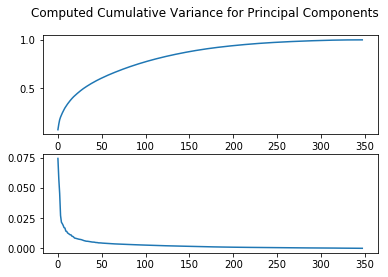

In [210]:
## draw grapg from pca variance per principal component

cumulativeVariance = list(accumulate(varianceSeries))

#print(cumulativeVariance)
print(len(cumulativeVariance))

xValues = [1] * len(cumulativeVariance)
xValues[0] = 0
xValues = list(accumulate(xValues))
xColumn = pd.DataFrame({'X' : xValues})
yColumn = pd.DataFrame({'Y' : cumulativeVariance})
oYColumn = pd.DataFrame({'OY' : list(varianceSeries)})
data = pd.concat([xColumn, yColumn], axis = 1)

#print(data.head(10))

## plot

fig, ax = plt.subplots(2)
fig.suptitle('Computed Cumulative Variance for Principal Components')
#ax.set_title('Computed Cumulative Variance for Principal Components')
ax[0].plot(xColumn, yColumn)
ax[1].plot(xColumn, oYColumn)



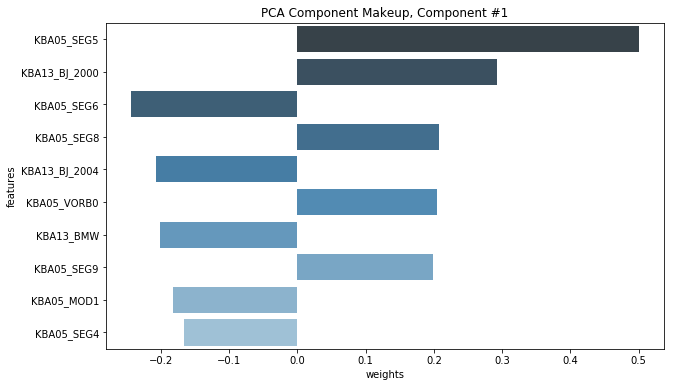

In [237]:
#features_list = list(customersC.columns)
n_weights = 10
N_COMPONENTS = column - 1

def display_component(v, features_list, component_num, n_weights=10):

    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v[:, row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


num = 1
display_component(pca.components_, list(customersC.columns), component_num=num, n_weights=10)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')